<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/ResNet_34_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
model = torchvision.models.resnet34(pretrained=True).cuda()
model.fc = torch.nn.Linear(512, 10)
model= torch.load("/content/cifar_interpretability_test.pth")

In [ ]:
print(model)

In [19]:
activation = {'conv1':0,'layer1':0,'layer2':0,'layer3':0,'layer4':0}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.conv1.register_forward_hook(get_activation('conv1'))
model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.layer4.register_forward_hook(get_activation('layer4'))

In [5]:
from tqdm.notebook import tqdm
images = []
features = []
trans = transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
dataset_imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=trans)
dataloader_imgs = torch.utils.data.DataLoader(dataset_imgs, batch_size=1)


toPil = transform=transforms.Compose([
        transforms.ToPILImage()
    ])

imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor()
        ]))
imgs = torch.utils.data.DataLoader(imgs, batch_size=1)



Files already downloaded and verified
Files already downloaded and verified


In [6]:
!pip install faiss-cpu

In [6]:
import numpy as np
import faiss

In [7]:
images = []
targets = []
for img, target in tqdm(imgs):
      images.append(toPil(img.squeeze(0)))
      targets.append(target.item())

Test Image Incorrectly Classified as Horse

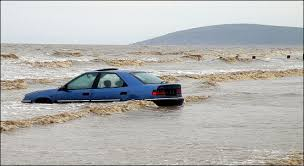

In [55]:
overall_layer = 0
for key in activation.keys():
    count = 0
    features = []
    targets = []
    for (tensor, y) in tqdm(dataloader_imgs):
      output = model(tensor.cuda())
      targets.append(y.item())
      features.append(torch.flatten(activation[key]).cpu().detach().numpy())
      count+=1
      if(count == 100):
        break;

    D = len(features[0])
    N = len(features)
    # X = np.random.random((len(features), len(features[0]))).astype(np.float32)  # inputs of faiss must be float32

    X = np.asarray(features)

   
    index = faiss.IndexFlatL2(D)

    index.add(X)
  
    topk = 5

    for (test_image, label) in tqdm(data_loader):
        test_output = model(tensor.cuda())
        test_features= torch.flatten(activation[key]).cpu().detach().numpy()
    true_target = torch.argmax(test_output).item()
    print("Predicted Target ",true_target)

    dists, ids = index.search(x=np.asarray([test_features]), k=topk)


    num_correct = 0
    for i in ids[0]:
      if(targets[i] == true_target):
        num_correct +=1
      # print(targets[i])
    print(num_correct)


    
    print(dists)
    print(ids)


    if(num_correct >= overall_layer):
      debug_imgs = ids[0]
      print(key)
 



    # Show params
    print("N:", index.ntotal)
    print("D:", index.d)


tensor([[-0.2103, -2.7151,  1.2895,  1.2446,  1.1794,  1.1646, -0.1153,  1.6415,
         -2.1724, -1.4981]], device='cuda:0', grad_fn=<AddmmBackward>)
Predicted Target  7
1
[[      0.  2995726.  3834162.5 3949746.  4055576.5]]
[[99 70 72 88 74]]
conv1
N: 100
D: 802816



tensor([[-0.2103, -2.7151,  1.2895,  1.2446,  1.1794,  1.1646, -0.1153,  1.6415,
         -2.1724, -1.4981]], device='cuda:0', grad_fn=<AddmmBackward>)
Predicted Target  7
2
[[    0.    69292.586 70450.75  76302.23  76741.484]]
[[99 87 79 34 74]]
layer1
N: 100
D: 200704



tensor([[-0.2103, -2.7151,  1.2895,  1.2446,  1.1794,  1.1646, -0.1153,  1.6415,
         -2.1724, -1.4981]], device='cuda:0', grad_fn=<AddmmBackward>)
Predicted Target  7
1
[[    0.    21763.967 21867.64  21919.254 21964.447]]
[[99 72 79 34 54]]
layer2
N: 100
D: 100352



tensor([[-0.2103, -2.7151,  1.2895,  1.2446,  1.1794,  1.1646, -0.1153,  1.6415,
         -2.1724, -1.4981]], device='cuda:0', grad_fn=<AddmmBackward>)
Predicted Target  7
1
[[   0.     5086.765  5277.981  5293.709  5334.4365]]
[[99 71 84  7 15]]
layer3
N: 100
D: 50176



tensor([[-0.2103, -2.7151,  1.2895,  1.2446,  1.1794,  1.1646, -0.1153,  1.6415,
         -2.1724, -1.4981]], device='cuda:0', grad_fn=<AddmmBackward>)
Predicted Target  7
2
[[    0.    10227.814 10249.505 10329.981 10384.074]]
[[99 71 58 46 69]]
layer4
N: 100
D: 25088


In [35]:
from PIL import Image
num = 0
for i in debug_imgs:
  images[i].save("image"+str(num)+".png")
  num+=1
  

In [54]:
from PIL import Image
num = 0
for i in debug_imgs:
  images[i].save("ood"+str(num)+".png")
  num+=1

## Single Image High Resolution

In [ ]:
!git clone https://github.com/krasserm/super-resolution.git

In [ ]:
!cp -r super-resolution/model/ /content/
!cp super-resolution/utils.py /content/

In [ ]:
from model.srgan import generator
from utils import load_image, plot_sample
from model.common import resolve_single

model_hr = generator()
model_hr.load_weights('/content/drive/My Drive/Interpretability Experiments/srgan_weights/srgan/gan_generator.h5')

lr = load_image('image2.png')[:,:,:3]
sr = resolve_single(model_hr, lr)
print("Testing Single Image Super Resolution")
plot_sample(lr, sr)
